# Sea surface temperature: historical map
----

J. Potemra<br>
February 2024

----
This notebook will access satellite-derived sea surface temperature (SST) and produce maps of the seasonal mean SST's in the region (4-panel plot for DJF/MAM/JJA/SON).

The data used are a Global High-resolution SST (GHRSST) product, specifically the Level-4, daily Global SST & Sea Ice Analysis from the UK Met Office (METOFFICE-GLO-SST-L4-REP-OBS-SST-V2)<sup>1</sup>.

The OSTIA global sea surface temperature reprocessed product provides daily gap-free maps of foundation sea surface temperature and ice concentration (referred to as an L4 product) at 0.05<sup>o</sup> x 0.05<sup>o</sup> horizontal grid resolution, using re-processed ATSR data, AVHRR Pathfinderdata and _in-situ_ data from ICOADS. This product provides the foundation Sea Surface Temperature, which is the temperature free of diurnal variability.

In this notebook the data are accessed from the Asia-Pacific Data Research Center (http://apdrc.soest.hawaii.edu) via an OPeNDAP call, and we use the period __1982__ through __2020__ for the seasonal climatology.

-------
<sup>1</sup>C.J. Donlon, M. Martin,J.D. Stark, J. Roberts-Jones, E. Fiedler, W. Wimmer. The operational sea surface temperature and sea ice analysis (OSTIA) system. Remote Sensing Environ., 116 (2012), pp. 140-158 http://dx.doi.org/10.1016/j.rse.2010.10.017 Please abide by their data use policy and acknowledge the use of these data with the following statement: These data were provided by GHRSST, Met Office and CMEMS.

## Import needed packages

In [1]:
# data I/O and processing
import xarray as xr
import pandas as pd
import numpy as np
import pickle

# data plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd

## Define functions to read data
The data are available on the APDRC OPeNDAP server at http:/apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/GHRSST/ghrsst_global_UKMO_OSTIA_REP.  Here we define two functions to read the data.  One __get_remote__ is from the OPeNDAP call.  Note this can take a _very_ long time (hours) if a large request is made.  The data are daily going back to 1981.  The other function, __get_local__ reads the data from a local disk.  This is much quicker, but relies on the data being in yearly "pickle" files.


In [2]:
# get the data from the APDRC OPeNDAP server; need to supply the latitude and longitude ranges
# along with start and end year
def get_remote(min_lon,max_lon,min_lat,max_lat,min_year,max_year):
    min_date = min_year + '-01-01'
    max_date = max_year + '-12-31'
    
    # set URL
    url = 'http:/apdrc.soest.hawaii.edu:80/dods/public_data/satellite_product/GHRSST/ghrsst_global_UKMO_OSTIA_REP'

    # read data
    ds = xr.open_dataset(url)
    
    # slice the data to region and time
    ds = ds.sel( lat = slice(min_lat,max_lat), lon = slice(min_lon,max_lon), time=slice(min_date,max_date))
    return ds

In [3]:
# get data from local disk; note that in this case the data are in annual files, so just
# need specify start and end years
def get_local(min_year,max_year):
    iter = 0
    for year in range (int(min_year),int(max_year)+1):
        infile = './data/GHRSST_' + str(year) + '.pkl'
        fileObject = open(infile,'rb')
        ds1 = pickle.load(fileObject)
        fileObject.close()
        ds = ds1 if iter==0 else xr.merge([ds,ds1])
        iter += 1
    return ds

## Define lat/lon/time ranges for analysis and display

In [4]:
# define lat/lon range for Palau
min_lat = 0.0
max_lat = 13.0
min_lon = 128.0
max_lon = 138.0

# define time range
min_year = 1982
max_year = 2020

## Read data
Note the data is not read until "needed."  In this case, not until monthly mean calculation.  This takes a long time, especially with a long time-range, since the data are daily.  Instead there is the option to read the data from local disk (read once, then access faster).  Note that the "read from local disk" still takes about 25 minutes.

In [5]:
# do a remote OPeNDAP read
#ds = get_remote(min_lon,max_lon,min_lat,max_lat,min_year,max_year)
# do a local read
ds = get_local(min_year,max_year)

# also read the EEZ as a shape file
shape_gpd = gpd.read_file('./data/pw_eez_line_april2022.shp')

## Compute the monthly means, then climatological year

In [6]:
# start with daily files, create monthly means; Note data are in Kelvin
mmean_sst = ds['sst'].resample(time='1MS').mean(dim='time') - 273.15

# create a monthly mean climatology
climatology_mean = mmean_sst.groupby('time.month').mean('time')

# create DJF, MAM, JJA, SON means
seasonal_mean = mmean_sst.groupby('time.season').mean(dim='time')

# the seasons are define as DJF, MAM, etc.; the variable below is
# used later in plotting
cmonth = {'DJF':'Dec-Jan-Feb',
          'MAM':'Mar-Apr-May',
          'JJA':'Jun-Jul-Aug',
          'SON':'Sep-Oct-Nov'}

## Make a plot
Here we define a couple functions to add fancy axes and maps/coastlines to our figures.  First we set some "global attributes" like the geographic extent of the maps, map projection, _etc._

In [7]:
# Plot parameters
# geographic range; Note here use the maximum extent of the data, but
# we could also do a smaller (clipped) or large (white space) region
lon_range = [min_lon, max_lon]
lat_range = [min_lat, max_lat]

# color range for shading (in degrees C)
color_min, color_max = 28, 30

# projection
crs = ccrs.PlateCarree()

In [8]:
# add alternating black and white bars to map axes
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))
    
    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        #color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        #color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)

# plot the land and coastlines
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

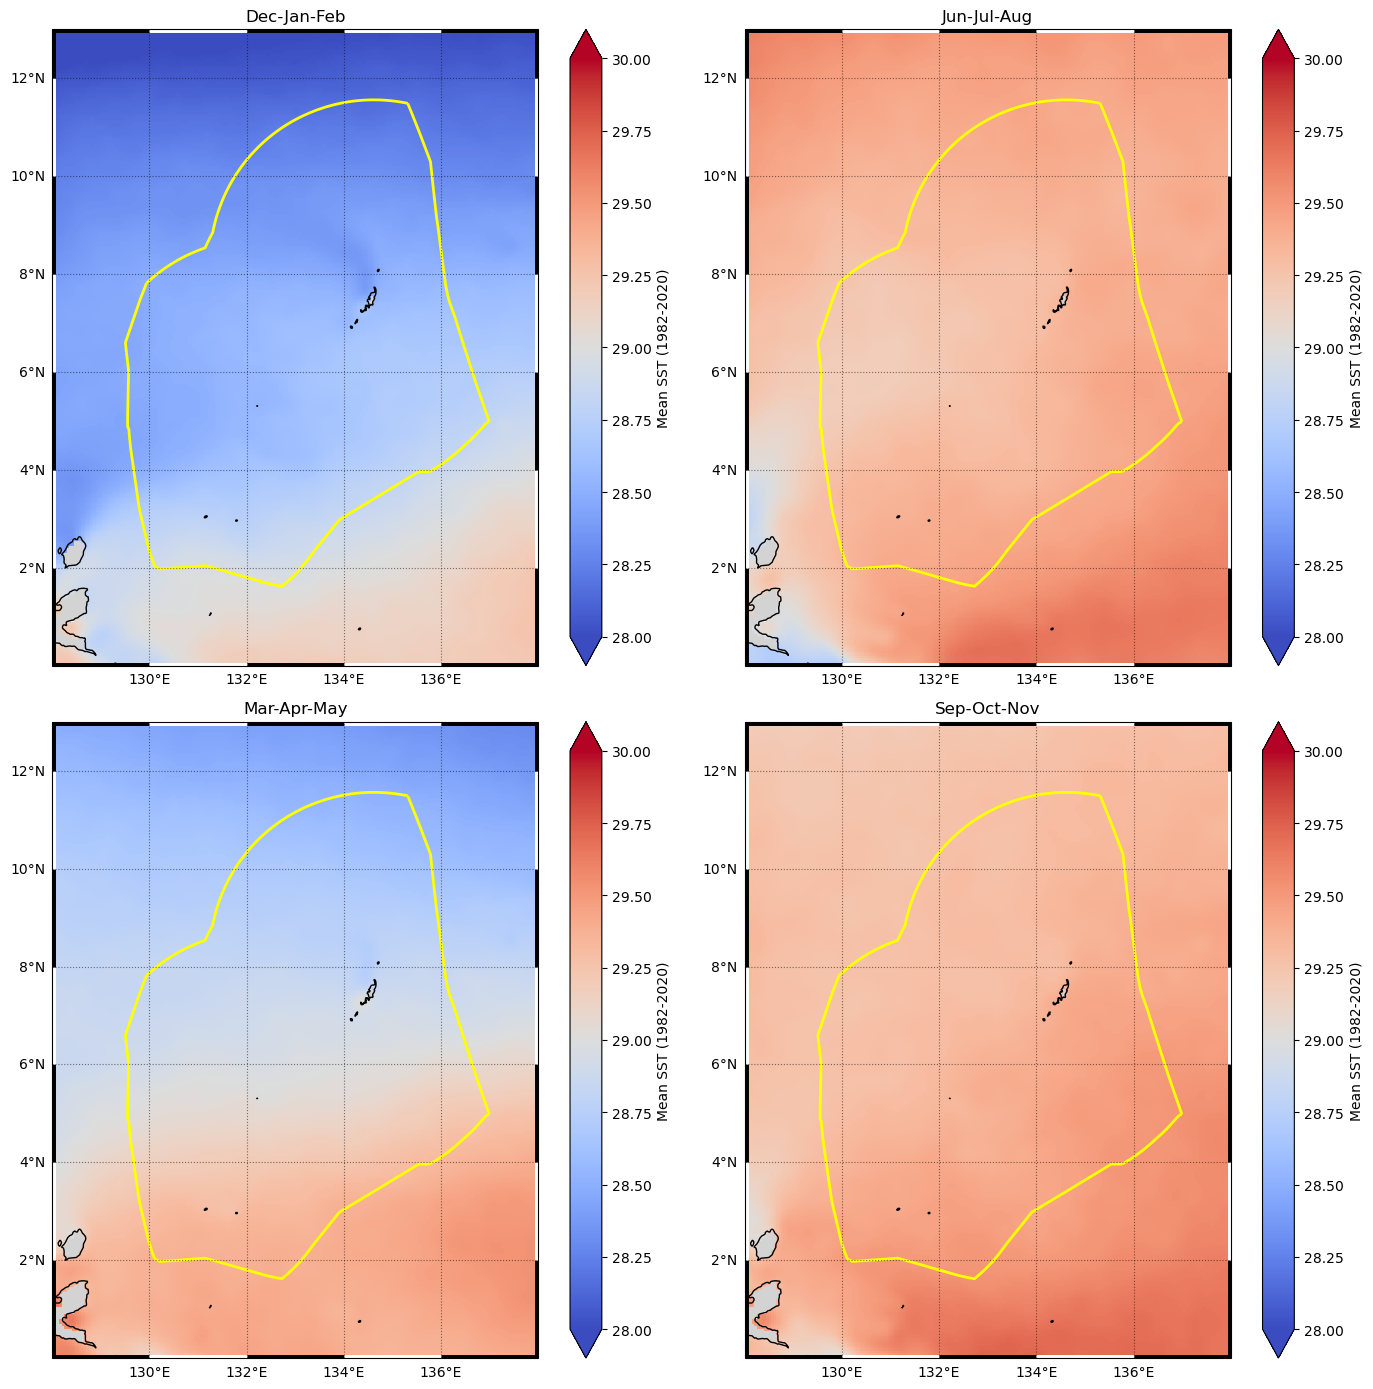

In [10]:
# make a four-panel plot

cmap = sns.color_palette("coolwarm", as_cmap=True)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(14,14), subplot_kw={'projection': crs} )
fig, ax = plt.subplots( nrows=2, ncols=2, figsize=(14,14), subplot_kw={'projection': crs} )

k = 0
for i in range(2):
    for j in range (2):
        plot_title = cmonth[np.array2string(seasonal_mean['season'][k].values).strip('\'')]
        seasonal_mean[k,:,:].plot( ax=ax[i,j], transform=crs, robust=True,
                                   vmin=color_min, vmax=color_max, 
                                   cmap=cmap, add_colorbar=True, extend='both',
                                   cbar_kwargs={'label': 'Mean SST (1982-2020)'},)
        ax[i,j].set_xlim(lon_range)
        ax[i,j].set_ylim(lat_range)
        cmap = sns.color_palette("coolwarm", as_cmap=True)
        ax[i,j].coastlines()
        ax[i,j].add_feature(cfeature.LAND, color='lightgrey')      
        ax[i,j].set_title(plot_title)

        # Call the function to add the zebra frame
        plot_zebra_frame(ax[i,j], lw=5, segment_length=2.0, crs=crs)

        # add the EEZ
        shape_gpd.plot(ax=ax[i,j],color='yellow',transform=crs, linewidth=2);

        k += 1
plt.tight_layout()
plt.savefig('./images/temp_hist_map.png')